In [1]:
import numpy as np
from scipy.stats import special_ortho_group
import jax.numpy as jnp
from jax import grad, vmap
from Mondrian_forest import *
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import pickle

dim_in = 5
active = 3
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = jnp.dot(x, rotation)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = jnp.dot(res ** 4, projected)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 2000
n_test = 500
tries = 10

x_train, y_train, x_test, y_test, rotation = pickle.load(open('data.pickle', 'rb'))

x_test = x_test[:n_test]
y_test = y_test[:n_test]

'''
rotation = special_ortho_group.rvs(dim_in)
x_train = np.random.rand(n,dim_in)*2 - 1
y_train = simulate_y(x_train, rotation)

x_test = np.random.rand(1000,dim_in)*2 - 1
y_test = simulate_y(x_test, rotation)
'''

sample_range = [100, 200, 400, 800, 1600]

M = 10                      # number of Mondrian trees to use
delta = 0                   # ridge regression delta

In [2]:
W_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_test, rotation)
from numpy import linalg
true_H = jnp.matmul(jnp.transpose(W_grad), W_grad) / n_test
norm_H = linalg.norm(true_H, ord = 2)

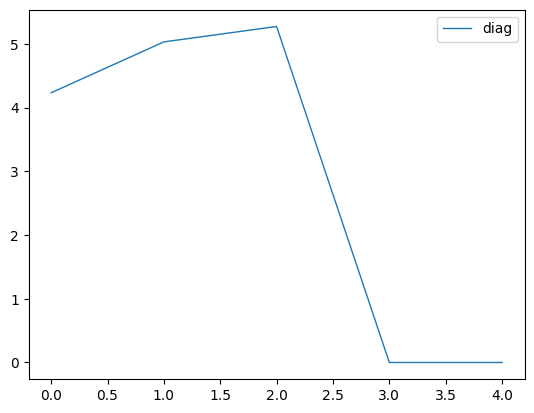

In [3]:
eigenvalues, eigenvectors = linalg.eig(true_H)
draw(dim_in, eigenvalues)

In [4]:
def plot_trend(stats, x_axis, y_axis, title, xlabel = None, ylabel = None):
    df = pd.DataFrame(stats)

    # Prepare the data for plotting
    plot_data = [df[y_axis][i] for i in range(len(df))]

    # Create the boxplot
    plt.boxplot(plot_data, labels=[str(x[x_axis]) for x in stats])

    # Add titles and labels
    plt.title(title)
    if xlabel is None:
        xlabel = x_axis
    if ylabel is None:
        ylabel = y_axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Show the plot
    plt.show()

In [5]:
'''
lifetime_max = 5
for n_sim in tqdm(sample_range):
    results = evaluate_all_lifetimes(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max, delta)
    print("min mse: " + str(min(results['mse'])))
    print("time: " + str(results['times'][np.where(results['mse'] == min(results['mse']))[0][0]]))
    plt.plot(results['times'], results['mse'], label = 'n = ' + str(n_sim))
    plt.legend()
'''

'\nlifetime_max = 5\nfor n_sim in tqdm(sample_range):\n    results = evaluate_all_lifetimes(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max, delta)\n    print("min mse: " + str(min(results[\'mse\'])))\n    print("time: " + str(results[\'times\'][np.where(results[\'mse\'] == min(results[\'mse\']))[0][0]]))\n    plt.plot(results[\'times\'], results[\'mse\'], label = \'n = \' + str(n_sim))\n    plt.legend()\n'

# Save training history

In [6]:
lifetime = 4

stats = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        y_hat_test, history, X_bd_all = \
            one_run(x_train[:n_sim, ], y_train[:n_sim], x_test, M, lifetime, delta)
        dist['history'].append((y_hat_test, history, X_bd_all))
    stats.append(dist)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [21:53<00:00, 131.33s/it]


# With increasing lifetime

In [7]:
def get_H_estimates(stats, x_train, x_test, y_test, M, delta, estimate_H):
    H_est = []
    for i in range(len(sample_range)):
        n_sim = sample_range[i]
        dist = {'n': n_sim, 'mse': [], 'H': []}
        for trial in tqdm(range(tries)):
            y_hat_test, history, X_bd_all = \
                stats[i]['history'][trial]
            dist['mse'].append(mean_squared_error(y_test, y_hat_test))
            H_0 = estimate_H(x_train[:n_sim, ], y_train[:n_sim], X_bd_all, M, x_test, history, delta, y_hat_test)
            dist['H'].append(H_0)
        H_est.append(dist)
        
    return H_est

raw_H_estimates = get_H_estimates(stats, x_train, x_test, y_test, M, delta, estimate_H_ind)

100%|██████████| 10/10 [05:03<00:00, 30.37s/it]


In [48]:
def operator_norm(H, truth):
    norm_truth = norm(truth, ord = 2)
    return norm(truth - H, ord = 2)/norm_truth

def get_eig(A):
    eigenValues, eigenVectors = linalg.eig(A)

    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    print(eigenValues)
    eigenVectors = eigenVectors[:,idx]
    return eigenVectors

def get_angle_distance(H, truth):
    dim_proj = active
    proj = np.identity(dim_proj)
    proj = np.pad(proj, [(0, dim_in - dim_proj), (0, dim_in - dim_proj)], mode='constant')
    
    eigenvectors = get_eig(H)
    Q_H, _ = linalg.qr(eigenvectors[:, :active])
    
    eigenvectors = get_eig(truth)
    Q_t, _ = linalg.qr(eigenvectors[:, :active])

    D = np.matmul(np.transpose(Q_H), Q_t)
    U, S, Vh = np.linalg.svd(D, full_matrices=True)
    S = np.minimum(S, 1)
    return np.max(np.arccos(S))

['0.9942', '0.9954', '0.9927', '0.9943', '0.9944', '0.9939', '0.9932', '0.9945', '0.9911', '0.9941']
['0.9901', '0.9935', '0.9928', '0.9933', '0.9892', '0.9925', '0.9921', '0.9936', '0.9930', '0.9929']
['0.9904', '0.9857', '0.9892', '0.9891', '0.9912', '0.9893', '0.9900', '0.9918', '0.9864', '0.9905']
['0.9886', '0.9870', '0.9861', '0.9874', '0.9859', '0.9845', '0.9887', '0.9865', '0.9839', '0.9840']
['0.9804', '0.9827', '0.9837', '0.9814', '0.9811', '0.9805', '0.9830', '0.9804', '0.9827', '0.9785']


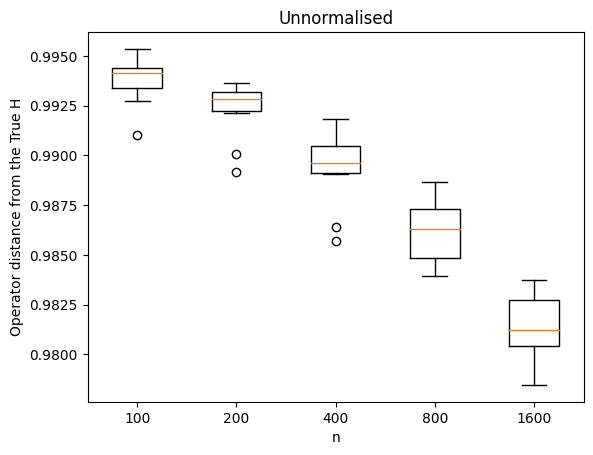

['0.6229', '0.9128', '0.8577', '0.6248', '0.6714', '0.8910', '0.6136', '0.8682', '0.9709', '0.6475']
['0.8656', '1.2350', '0.7956', '0.7195', '0.7005', '0.6467', '0.8061', '0.6669', '0.8701', '0.5550']
['0.6241', '0.7195', '0.5612', '0.6857', '0.8317', '0.6945', '0.7289', '0.6853', '0.7788', '0.7743']
['0.7043', '0.6866', '0.6169', '0.7060', '0.7047', '0.6373', '0.6530', '0.7415', '0.6651', '0.6615']
['0.6317', '0.7493', '0.7341', '0.5812', '0.6601', '0.8088', '0.6253', '0.7133', '0.6618', '0.6919']


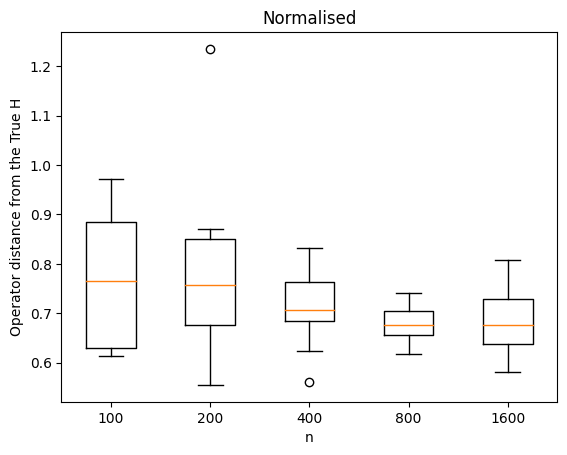

In [38]:
def plot_dist(H_estimates, title, true_H, norm_H, norm_func):
    plot_data = []
    for i in range(len(sample_range)):
        dist = H_estimates[i]
        n_sim = sample_range[i]
        alter_dist = {'n': n_sim, 'dist':[]}
        for trial in range(tries):
            H_0 = dist['H'][trial]
            alter_dist['dist'].append(norm_func(H_0, true_H))
        print([f'{x:.4f}' for x in alter_dist['dist']])
        plot_data.append(alter_dist)
    try:
        plot_trend(plot_data, 'n', 'dist', title, ylabel='Operator distance from the True H')
    except:
        pass


def plot_H_estimates(raw_H_estimates, true_H, norm_func):

    norm_H = norm(true_H, ord = 2)
    plot_dist(raw_H_estimates, 'Unnormalised', true_H, norm_H, norm_func)
    
    H_estimates = deepcopy(raw_H_estimates)
    normed_H_estimates = []
    for i in range(len(sample_range)):
        dist = H_estimates[i]
        for trial in range(tries):
            H_0 = dist['H'][trial]
            H_0 = H_0 / two_one_norm(H_0)
            dist['H'][trial] = H_0
        normed_H_estimates.append(dist)

    true_H_normed = true_H/two_one_norm(true_H)
    norm_H_normed = norm(true_H_normed, ord = 2)

    plot_dist(H_estimates, 'Normalised', true_H_normed, norm_H_normed, norm_func)


plot_H_estimates(raw_H_estimates, true_H, operator_norm)

[0.0485 0.0273 0.0245 0.0207 0.0192]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.08   0.0338 0.026  0.0232 0.0132]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.0486 0.0325 0.0261 0.0225 0.0198]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.0568 0.0382 0.0317 0.021  0.0183]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.0724 0.0387 0.0275 0.0197 0.0121]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.0814 0.0385 0.0255 0.0178 0.0136]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.0531 0.0317 0.0292 0.0281 0.0167]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.0768 0.0331 0.0207 0.0171 0.0163]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.0595 0.0522 0.0366 0.0265 0.009 ]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.0599 0.0534 0.0334 0.019  0.0095]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
['1.3488',

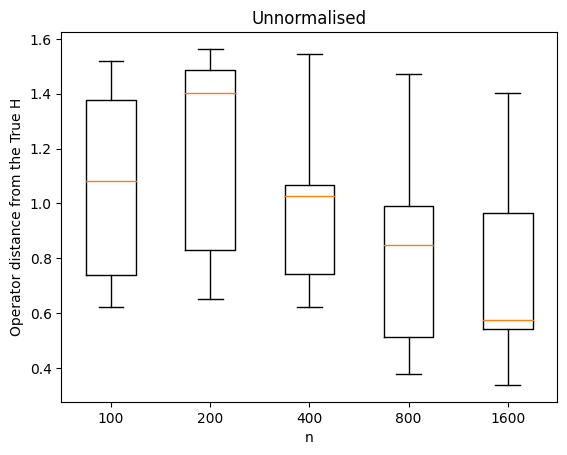

[1.7173 0.9672 0.8672 0.7345 0.6788]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[2.2393 0.9457 0.7289 0.6488 0.3692]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[1.6181 1.0797 0.8669 0.7488 0.6586]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[1.7038 1.1463 0.9496 0.6299 0.5479]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[2.1074 1.1261 0.7994 0.5743 0.3513]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[2.2197 1.0507 0.6943 0.4859 0.3702]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[1.667  0.9945 0.9163 0.8826 0.5248]
[ 1

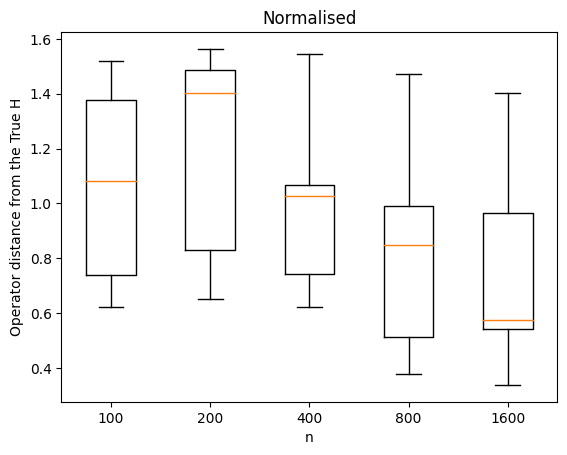

In [50]:
np.set_printoptions(precision=4)
plot_H_estimates(raw_H_estimates, true_H, get_angle_distance)

# Eliza's method for estimating gradients

In [13]:
def estimate_H_ind_(x_train, y_train, X_bd_all, M, X_test, history, delta, y_hat_test):
    dim_in = X_test.shape[1]
    N_test = X_test.shape[0]
    importance = []
    for dim in range(dim_in):
        try:
            x_eval = None
            y_eval = []
            x_diff = []
            subset_all = []
            for tree in range(M):
                temp = X_bd_all[tree,dim] - X_test
                subset = temp[:,dim] != 0
                subset_all = subset_all + list(subset)
                
                if sum(subset) > 0:
                    if x_eval is None:
                        x_eval = X_bd_all[tree,dim][subset]
                    else:
                        x_eval = np.vstack((x_eval, X_bd_all[tree,dim][subset]))
                    y_eval = y_eval + y_hat_test[subset].tolist()
                    x_diff = x_diff + list(temp[:,dim][subset])
            
            _, y_hat_eval = evaluate(x_train, y_train, x_eval, M, history, delta)
            y_eval = np.array(y_eval)
            x_diff = np.abs(x_diff)
            y_diff = populate_importance(subset_all, y_eval - y_hat_eval)
            x_diff = populate_importance(subset_all, x_diff)
            y_diff = np.reshape(y_diff, (N_test, M))
            x_diff = np.reshape(x_diff, (N_test, M))
            y_diff = np.mean(y_diff, axis = 1)
            x_diff = np.mean(x_diff, axis = 1)
            y_diff[x_diff == 0] = 0
            x_diff[x_diff == 0] = 1
            importance_temp = y_diff/x_diff
        except:
            importance_temp = np.zeros(N_test)
        importance.append(importance_temp)
    importance = np.vstack(importance)

    H = np.matmul(importance, np.transpose(importance))/N_test
    return H

alter_H_estimates = get_H_estimates(stats, x_train, x_test, y_test, M, delta, estimate_H_ind_)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [03:55<00:00, 23.50s/it]


['0.9775', '0.9863', '0.9808', '0.9776', '0.9855', '0.9864', '0.9814', '0.9852', '0.9850', '0.9831']
['0.9770', '0.9771', '0.9777', '0.9704', '0.9771', '0.9819', '0.9796', '0.9785', '0.9793', '0.9794']
['0.9813', '0.9754', '0.9743', '0.9843', '0.9803', '0.9758', '0.9822', '0.9799', '0.9768', '0.9787']
['0.9764', '0.9749', '0.9709', '0.9666', '0.9710', '0.9707', '0.9763', '0.9657', '0.9743', '0.9721']
['0.9671', '0.9644', '0.9740', '0.9722', '0.9694', '0.9715', '0.9718', '0.9685', '0.9730', '0.9610']


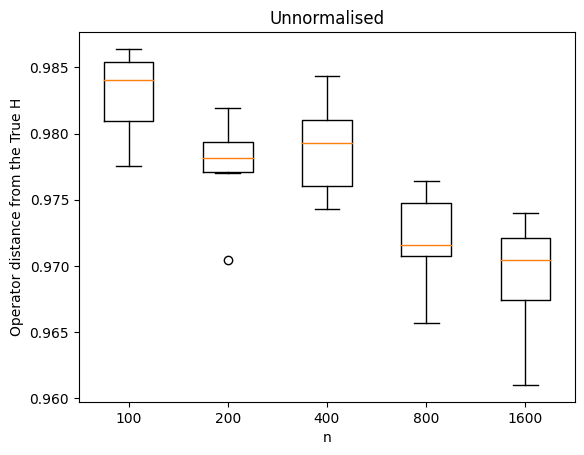

['0.6517', '0.5607', '0.9555', '0.6847', '1.1002', '0.6542', '0.6502', '0.7651', '0.6359', '0.6548']
['0.6710', '0.7012', '0.6950', '0.7811', '0.6531', '0.7531', '0.5919', '0.6670', '0.6908', '0.6882']
['0.5876', '0.7312', '0.6584', '0.6182', '0.6908', '0.7593', '0.6350', '0.6365', '0.8049', '0.7040']
['0.7204', '0.6310', '0.5448', '0.5742', '0.7068', '0.6232', '0.6971', '0.6667', '0.7885', '0.7742']
['0.5913', '0.5887', '0.6133', '0.6785', '0.6003', '0.8706', '0.6127', '0.6825', '0.6875', '0.5731']


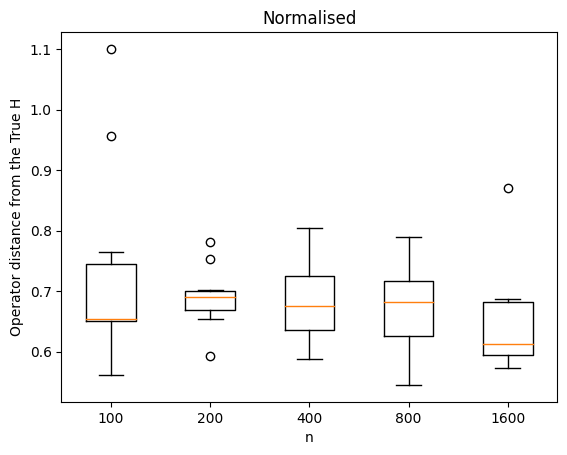

In [52]:
plot_H_estimates(alter_H_estimates, true_H, operator_norm)

[0.1527 0.1249 0.1004 0.0895 0.0507]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.1206 0.0794 0.0674 0.0561 0.0508]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.1363 0.107  0.0833 0.0525 0.0366]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.141  0.1269 0.0824 0.0746 0.0382]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.1652 0.1128 0.0854 0.0662 0.0483]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.1152 0.0863 0.0661 0.059  0.0307]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.1129 0.1106 0.0902 0.0695 0.0586]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.1074 0.0926 0.0881 0.0742 0.0305]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.1048 0.0901 0.0671 0.0576 0.021 ]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
[0.1221 0.1036 0.0782 0.0711 0.0603]
[ 5.2726e+00  5.0309e+00  4.2324e+00 -1.0852e-09 -1.0184e-07]
['0.4806',

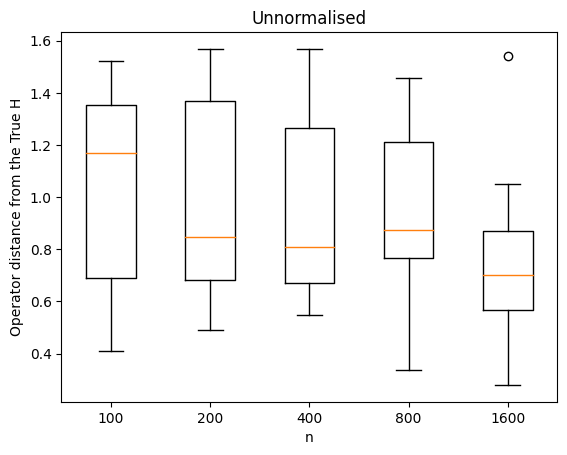

[1.4619 1.1962 0.9616 0.857  0.4855]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[1.6017 1.055  0.8949 0.7457 0.6748]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[1.6255 1.2763 0.9943 0.6265 0.4372]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[1.5092 1.3577 0.882  0.7981 0.4088]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[1.7085 1.1665 0.8838 0.6848 0.4997]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[1.5986 1.1976 0.917  0.8191 0.4267]
[ 1.5116e+00+0.0000e+00j  1.4422e+00+0.0000e+00j  1.2133e+00+0.0000e+00j
 -8.7182e-09+1.1166e-08j -8.7182e-09-1.1166e-08j]
[1.2696 1.2435 1.014  0.7813 0.6594]
[ 1

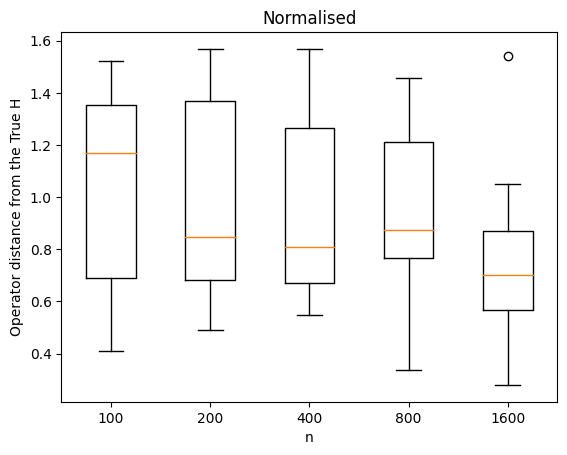

In [53]:
plot_H_estimates(alter_H_estimates, true_H, get_angle_distance)